# 8. Cross-Validation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/8.Cross-Validation.ipynb)

(Based on https://aamir07.medium.com/polynomial-regression-with-k-fold-cross-validation-bc5275137546)

In this notebook, we will apply k-fold cross-validation to determine the optimol degree of polynomial features in polynomial regression, a model hyperpararameter.

## Polynomial Regression

Polynomial is actually a form of linear regression. We simply change the features to be polynomials of our input data $x_i$. It is linear regression, because the resulting model is linear in the parameters, $\beta_i$:
$$
\hat y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \dots
$$
or in matrix form
$$
\begin{bmatrix} \hat y_1 \\ \hat y_2 \\ \vdots \\ \hat y_n \end{bmatrix} =
\begin{bmatrix}
   1 & x_1 & x_1^2 & x_1^3 & \dots \\
   1 & x_2 & x_2^2 & x_2^3 & \dots \\
   \vdots \\
   1 & x_n & x_n^2 & x_n^3 & \dots 
\end{bmatrix}
\begin{bmatrix}
   \beta_0 \\
   \beta_1 \\
   \beta_2 \\
   \beta_3 \\
   \vdots
\end{bmatrix}.
$$
$$
\hat{\bf y} = {\bf X}\beta.
$$

The coefficients, $\beta_i$, that minimize our cost function, given by the mean-squared error, fullfill the normal equation:
$$
{\bf X}^\mathrm{T} {\bf X} \beta = {\bf X}^\mathrm{T} {\bf y}.
$$

## K-fold Cross Validation

k-fold Cross Validation is a technique for model selection where the training data set is divided into $k$ equal groups. The first group is considered as the validation set and the rest $k-1$ groups as training data and the model is fit on it. This process is iteratively repeated $k-1$ times. Each time the $k^\mathrm{th}$ group will be selected as validation and the remaining $k-1$ groups be used for optimizing the model parameters, $\beta$. In each iteration, the validation MSE is calculated and the final MSE after $k$ iterations the Cross-Validation MSE is given as the average:
$$
\text{CV}_k = \frac{1}{N_k} \sum_{i=1}^k \text{MSE}_i
$$
This validation MSE is the estimate for our test data MSE.

<img src="https://github.com/rhennig/EMA6938/blob/main/Notebooks/Figures/Cross-Validation.png?raw=1" alt="Confusion Matrix" align="right" style="width:400px; float:right"/>

Importantly, **cross-validation is for model selection or hyperparameter optimization** and utilizes the training data. To measure the **performance of our model**, we need to apply it to data that was not used in the optimization of the hyperparameters or model parameters. Usually, we keep a fraction of 20% of the data aside as a **holdout test set** and use 80% of the data for the training set used in cross-validations. We measure the model performance of the optimized model on the holdout test set.

In [1]:
# Import the numpy, panda, sklearn, and matplotlib libraries
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 

In [2]:
# Generate a data set for machine learning
np.random.seed(seed=0)
x=np.linspace(0,2,300)
x=x+np.random.normal(0,.3,x.shape)
y=np.cos(x)+2*np.sin(x)+3*np.cos(x*2)+np.random.normal(0,1,x.shape)

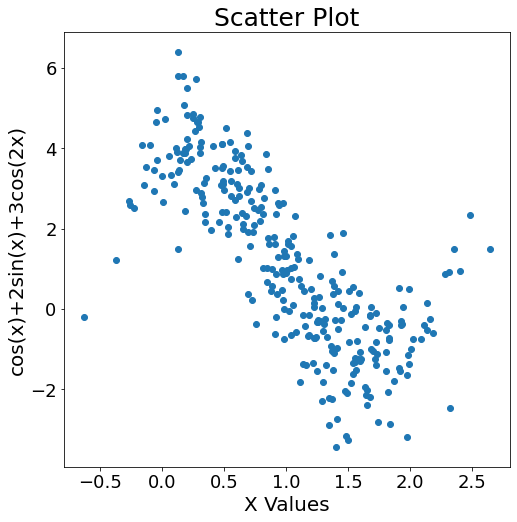

In [3]:
# Plot the whole dataset
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x, y)
ax.set_xlabel('X Values',fontsize=20)
ax.set_ylabel('cos(x)+2sin(x)+3cos(2x)',fontsize=20)
ax.set_title('Scatter Plot',fontsize=25)
plt.show()

In [4]:
# Split the dataset into 80% for training and 20% for testing
x = x.reshape((300,1))
x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.8)

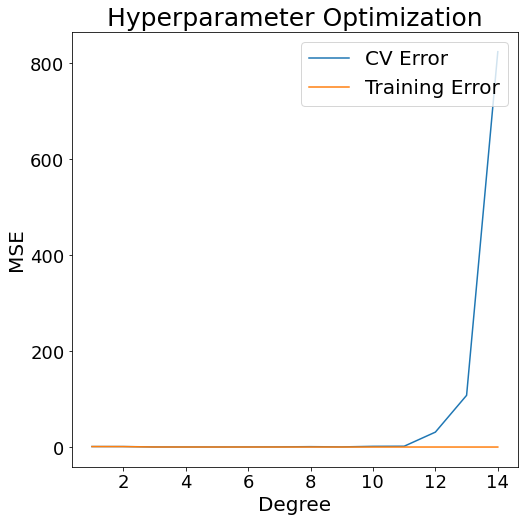

In [7]:
## Let's find out the model we need to select
maxdegree=10 # The maximum degree we would like to test
training_error=[]
cross_validation_error=[]

for d in range(1,maxdegree):
    x_poly_train=PolynomialFeatures(degree=d).fit_transform(x_train)    # Create the polynomial feature for the training
    x_poly_test=PolynomialFeatures(degree=d).fit_transform(x_test)      # and the testing
    lr=LinearRegression(fit_intercept=False)
    model=lr.fit(x_poly_train,y_train)                                  # Optimize the linear regression coefficients
    y_train_pred=model.predict(x_poly_train)                            # Predictions of the model
    mse_train=mean_squared_error(y_train,y_train_pred)                  # MSE on training data
    training_error.append(mse_train)

    # 5-fold cross validation to calculate the cross-validation MSE
    cve=cross_validate(lr, x_poly_train, y_train, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    cross_validation_error.append(np.mean(np.absolute(cve['test_score'])))  # Array of cross-validation MSE

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(range(1,maxdegree), cross_validation_error, label="CV Error")
ax.plot(range(1,maxdegree), training_error, label="Training Error")
ax.set_xlabel('Degree', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)
ax.set_title('Hyperparameter Optimization', fontsize=25)
ax.legend(loc='upper right', fontsize=20)
plt.show()

Optimal degree of polynomial regression =  5
MSE on holdout set =  1.1767066292208597


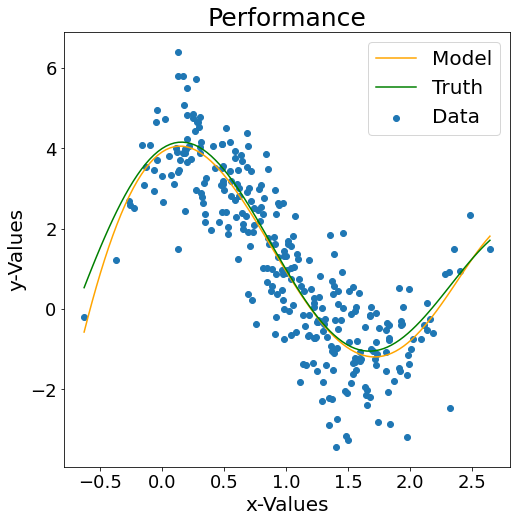

In [9]:
# Validate optimal model on holdout data set

# Select the optimal hyperparameter
degree = np.argmin(cross_validation_error)+1
print("Optimal degree of polynomial regression = ", degree)

# Fit the model parameters using the optimal hyperparameter
x_poly_train = PolynomialFeatures(degree).fit_transform(x_train)  # Create the polynomial features for the training set
lr           = LinearRegression(fit_intercept=False)
model        = lr.fit(x_poly_train,y_train)                       # Optimize the linear regression coefficient

# Measure performance of optimal model on holdout dataset
x_poly_test = PolynomialFeatures(degree).fit_transform(x_test)    # Create polynomial features on holdout set
y_test_pred = model.predict(x_poly_test)                          # Predictions of the model on holdout set
mse_test    = mean_squared_error(y_test,y_test_pred)              # MSE on holdout set

print("MSE on holdout set = ", mse_test)

# Calculate optimal polynomial regression
x_model = np.linspace(np.min(x), np.max(x), 100)
X_model = PolynomialFeatures(degree).fit_transform(np.array([x_model.flatten()]).T)
y_model_pred = model.predict(X_model)
y_truth = np.cos(x_model)+2*np.sin(x_model)+3*np.cos(x_model*2)

# Plot the whole dataset
fig,ax=plt.subplots(figsize=(8,8))
ax.scatter(x, y, label='Data')
ax.plot(x_model, y_model_pred, color='orange', label='Model')
ax.plot(x_model, y_truth, color='green', label='Truth')
ax.set_xlabel('x-Values', fontsize=20)
ax.set_ylabel('y-Values', fontsize=20)
ax.set_title('Performance', fontsize=25)
ax.legend(loc='upper right', fontsize=20)
plt.show()